<a href="https://colab.research.google.com/github/EkansTCG/AI-hw/blob/main/LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Number of features (including bias): 17
Final parameters (w):
[-2.81812415  1.15062258  0.9438823   0.90263357  0.79963672 -0.80930154
  0.9231349   1.16535245  1.08910937  1.05108592  0.01187094 -0.02516052
  1.0277117  -1.10211751 -1.24218015  0.09043226  0.08228028]


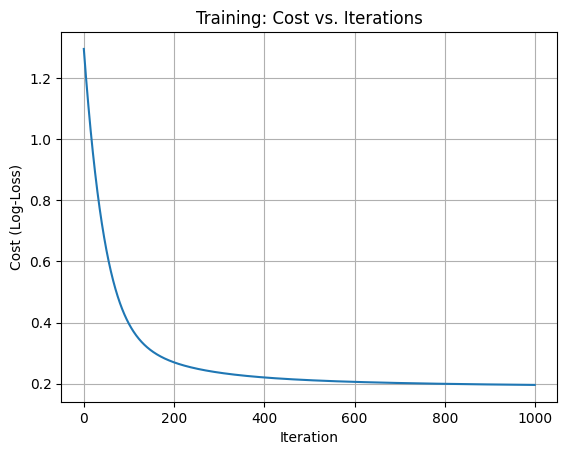

Plotting cost sensitivity for parameter indices: [14  7  1]


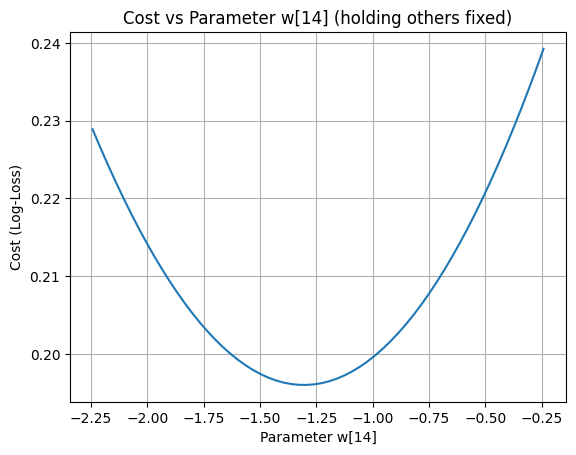

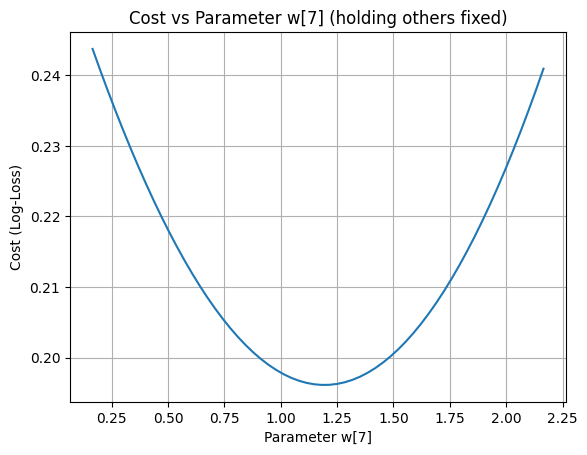

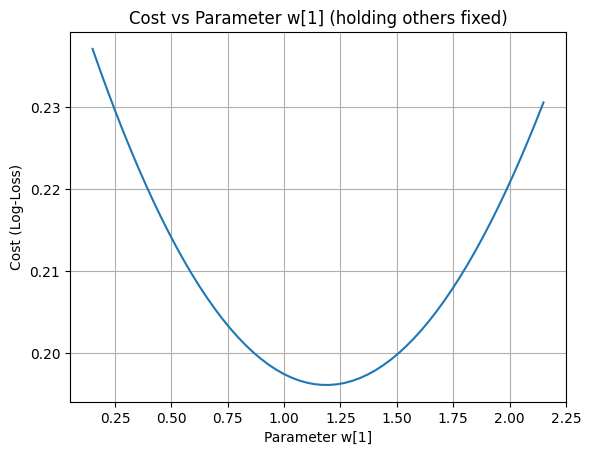

In [2]:
# ================================
# Logistic Regression (from scratch) — Skeleton (Filled)
# ================================

# 0) Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# 1) Load / prepare data
# --------------------------------------------------
# Assumptions (edit as needed):
#   - Binary classification with labels in {0,1}
#   - X is an (m, n) feature matrix (no bias column yet)
#   - y is an (m,) label vector

# Point to your CSV (from Kaggle or your uploaded file)
CSV_PATH = "synthetic_liver_cancer_dataset.csv"  # change if needed

def load_data():
    """Load CSV, auto-detect a binary target, one-hot encode categoricals,
    standardize features, and return X, y as numpy arrays."""
    df = pd.read_csv(CSV_PATH)

    # --- Detect target column ---
    lower = {c: c.lower().strip() for c in df.columns}
    inv   = {v: k for k, v in lower.items()}
    candidates = [
        "liver_cancer", "livercancer", "liver cancer", "cancer",
        "label", "class", "target", "diagnosis", "outcome", "is_cancer", "result"
    ]
    target_col = None
    for cand in candidates:
        if cand in inv:
            target_col = inv[cand]
            break
    if target_col is None:
        last = df.columns[-1]
        if df[last].nunique() == 2:
            target_col = last
    if target_col is None:
        for c in df.columns:
            if df[c].nunique() == 2:
                target_col = c
                break
    if target_col is None:
        raise ValueError("Could not determine a binary target column.")

    # Build X, y
    y_raw = df[target_col]
    X_df  = df.drop(columns=[target_col])

    # Target -> {0,1}
    if y_raw.dtype.kind in "biu":
        y_series = y_raw.astype(int)
    else:
        mapping = {
            "yes": 1, "y": 1, "true": 1, "t": 1, "positive": 1, "pos": 1, "cancer": 1, "malignant": 1,
            "no": 0,  "n": 0, "false": 0, "f": 0, "negative": 0, "neg": 0, "healthy": 0, "benign": 0
        }
        y_series = y_raw.astype(str).str.strip().str.lower().map(mapping)
        if y_series.isna().any():
            codes, uniques = pd.factorize(y_raw)
            if len(uniques) != 2:
                raise ValueError("Target column has more than 2 classes.")
            y_series = pd.Series(codes, index=y_raw.index)

    # One-hot encode categoricals, keep numeric as-is
    X_df = pd.get_dummies(X_df, drop_first=True)

    # (Optional) Feature scaling — often helps training stability
    X = X_df.to_numpy(dtype=float)
    y = y_series.to_numpy(dtype=int)
    mu = X.mean(axis=0, keepdims=True)
    sigma = X.std(axis=0, keepdims=True) + 1e-12
    X = (X - mu) / sigma

    # (Optional) Split the dataset into training and test
    # (The skeleton trains on full data; uncomment to split.)
    # from sklearn.model_selection import train_test_split
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # return X_train, y_train, X_test, y_test

    return X, y

# Load
data = load_data()
# If you uncommented the split above, adapt the next line accordingly
X, y = data
m = X.shape[0]

# Add bias column (x0 = 1)
X = np.column_stack([np.ones(m), X])  # shape: (m, n+1)
n_with_bias = X.shape[1]
print(f"Number of features (including bias): {n_with_bias}")


# 2) Utility functions: sigmoid, loss, gradient, prediction
# --------------------------------------------------
def sigmoid(z):
    # σ(z) = 1 / (1 + e^-z)
    z_clip = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z_clip))

def predict_proba(X, w):
    # p = σ(Xw)
    return sigmoid(X @ w)

def binary_cross_entropy(y_true, y_prob, eps=1e-12):
    # Log-loss = - [ y log(p) + (1-y) log(1-p) ]
    p = np.clip(y_prob, eps, 1 - eps)
    return -np.mean(y_true * np.log(p) + (1 - y_true) * np.log(1 - p))

def gradient(X, y_true, y_prob):
    # ∂J/∂w = (1/m) X^T (p - y)
    return (X.T @ (y_prob - y_true)) / X.shape[0]


# 3) Initialize parameters
# --------------------------------------------------
w = np.ones(n_with_bias)  # w[0] is bias term


# 4) Hyperparameters
# --------------------------------------------------
learning_rate = 0.1
num_iterations = 1000
# l2_reg = 0.0  # Optional L2, add to loss/grad if desired

# For tracking
cost_history = []


# 5) Gradient Descent loop
# --------------------------------------------------
for _ in range(num_iterations):
    # Forward pass: compute probabilities
    y_hat = predict_proba(X, w)

    # Compute loss (log-loss / cross-entropy)
    loss = binary_cross_entropy(y, y_hat)
    cost_history.append(loss)

    # Backward pass: compute gradient
    grad = gradient(X, y, y_hat)

    # Parameter update
    w -= learning_rate * grad


# 6) Final parameters
# --------------------------------------------------
print("Final parameters (w):")
print(w)  # w[0] is bias term


# 7) Plot: Cost vs Iterations
# --------------------------------------------------
plt.figure()
plt.plot(range(len(cost_history)), cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost (Log-Loss)")
plt.title("Training: Cost vs. Iterations")
plt.grid(True)
plt.show()


# 8) Plot: Cost vs 3 of the most important parameters
# --------------------------------------------------
# Identify top-3 parameters by |w| (excluding bias at index 0)
param_indices = np.argsort(np.abs(w[1:]))[::-1][:min(3, n_with_bias-1)] + 1
print("Plotting cost sensitivity for parameter indices:", param_indices)

def compute_cost_given_w(mod_w):
    # Helper to compute cost for a modified parameter vector
    y_hat_mod = predict_proba(X, mod_w)
    return binary_cross_entropy(y, y_hat_mod)

# For each chosen parameter, sweep values and compute cost
for idx in param_indices:
    center = w[idx]
    sweep = np.linspace(center - 1.0, center + 1.0, 60)

    costs = []
    for val in sweep:
        w_tmp = w.copy()
        w_tmp[idx] = val
        costs.append(compute_cost_given_w(w_tmp))

    plt.figure()
    plt.plot(sweep, costs)
    plt.xlabel(f"Parameter w[{idx}]")
    plt.ylabel("Cost (Log-Loss)")
    plt.title(f"Cost vs Parameter w[{idx}] (holding others fixed)")
    plt.grid(True)
    plt.show()


# 9) (Optional) Inference helper
# --------------------------------------------------
def predict_label(X_new, w, threshold=0.5):
    # Returns 0/1 predictions based on threshold
    return (predict_proba(X_new, w) >= threshold).astype(int)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the training data
y_pred = predict_label(X, w)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)

print("\nModel Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Model Evaluation Metrics:
Accuracy: 0.9192
Precision: 0.8456
Recall: 0.7695
F1-score: 0.8058
